# Analyse des Avis et Alertes ANSSI avec Enrichissement des CVE

## Étape 1 : Extraction des Flux RSS

In [35]:
# faire "pip install feedparser" si besoin dans le terminal 
import feedparser
import pandas as pd
from urllib.parse import urlparse

def extraire_type_et_id_depuis_url(url):
    path_parts = urlparse(url).path.strip("/").split("/")
    type_bulletin = path_parts[-2] if len(path_parts) >= 2 else None
    id_bulletin = path_parts[-1] if len(path_parts) >= 1 else None
    return type_bulletin, id_bulletin

def recuperer_bulletins_rss(url):
    rss_feed = feedparser.parse(url)
    bulletins = []
    for entry in rss_feed.entries:
        type_bulletin, id_bulletin = extraire_type_et_id_depuis_url(entry.link)
        bulletin = {
            "ID du bulletin (ANSSI)": id_bulletin,
            "Titre du bulletin (ANSSI)": entry.title,
            "Description": entry.description,
            "Lien du bulletin (ANSSI)": entry.link,
            "Date de publication": entry.published,
            "Type de bulletin": type_bulletin
        }
        bulletins.append(bulletin)
    return bulletins

# URLs RSS
avis_url = "https://www.cert.ssi.gouv.fr/avis/feed/"
alerte_url = "https://www.cert.ssi.gouv.fr/alerte/feed/"

# Récupération des données
avis_bulletins = recuperer_bulletins_rss(avis_url)
alerte_bulletins = recuperer_bulletins_rss(alerte_url)

# Fusion
bulletins = avis_bulletins + alerte_bulletins

# Afficher les bulletins pour vérification
for bulletin in bulletins:
    print(bulletin)

{'ID du bulletin (ANSSI)': 'CERTFR-2025-AVI-0392', 'Titre du bulletin (ANSSI)': 'Multiples vulnérabilités dans Mattermost Server (13 mai 2025)', 'Description': 'De multiples vulnérabilités ont été découvertes dans Mattermost Server. Elles permettent à un attaquant de provoquer une atteinte à la confidentialité des données et un contournement de la politique de sécurité.', 'Lien du bulletin (ANSSI)': 'https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-AVI-0392/', 'Date de publication': 'Tue, 13 May 2025 00:00:00 +0000', 'Type de bulletin': 'avis'}
{'ID du bulletin (ANSSI)': 'CERTFR-2025-AVI-0396', 'Titre du bulletin (ANSSI)': 'Multiples vulnérabilités dans les produits SAP (13 mai 2025)', 'Description': "De multiples vulnérabilités ont été découvertes dans les produits SAP. Certaines d'entre elles permettent à un attaquant de provoquer une exécution de code arbitraire à distance, une atteinte à la confidentialité des données et une injection de code indirecte à distance (XSS).", 'Lien du bul

## Étape 2 : Extraction des CVE

In [36]:
import requests
import re

def extraire_cves_depuis_bulletin(lien_bulletin):
    # Construit l'URL JSON à partir du lien du bulletin
    if not lien_bulletin.endswith('/'):
        lien_bulletin += '/'
    url_json = lien_bulletin + "json/"
    response = requests.get(url_json)
    data = response.json()
    # Extraction des CVE référencés dans la clé "cves"
    ref_cves = [cve.get("name") for cve in data.get("cves", [])]
    #attention il s’agit d’une liste des dictionnaires avec name et url comme clés
    print( "CVE référencés ", ref_cves)
    # Extraction des CVE avec une regex
    cve_pattern = r"CVE-\d{4}-\d{4,7}"
    cve_list = list(set(re.findall(cve_pattern, str(data))))
    print("CVE trouvés :", cve_list)
    return ref_cves, cve_list

tous_les_cves = set()
for bulletin in bulletins:
    ref_cves, cve_list = extraire_cves_depuis_bulletin(bulletin['Lien du bulletin (ANSSI)'])
    tous_les_cves.update(ref_cves)
    tous_les_cves.update(cve_list)
    bulletin["CVEs"] = list(set(ref_cves + cve_list))
    print(f"Bulletin {bulletin['Titre du bulletin (ANSSI)']} : CVEs = {bulletin['CVEs']}")




CVE référencés  ['CVE-2025-4128', 'CVE-2025-4573']
CVE trouvés : ['CVE-2025-4573', 'CVE-2025-4128']
Bulletin Multiples vulnérabilités dans Mattermost Server (13 mai 2025) : CVEs = ['CVE-2025-4573', 'CVE-2025-4128']
CVE référencés  ['CVE-2025-43003', 'CVE-2025-43007', 'CVE-2025-23191', 'CVE-2025-42999', 'CVE-2025-43009', 'CVE-2025-43011', 'CVE-2025-43006', 'CVE-2025-0060', 'CVE-2025-30012', 'CVE-2025-43000', 'CVE-2025-43004', 'CVE-2025-31324', 'CVE-2025-43005', 'CVE-2025-43008', 'CVE-2025-31329', 'CVE-2025-30009', 'CVE-2025-30011', 'CVE-2025-43002', 'CVE-2025-26662', 'CVE-2025-30010', 'CVE-2025-42997', 'CVE-2025-0061', 'CVE-2025-43010', 'CVE-2024-39592', 'CVE-2025-30018']
CVE trouvés : ['CVE-2025-30009', 'CVE-2025-43002', 'CVE-2025-0061', 'CVE-2025-43007', 'CVE-2025-43009', 'CVE-2025-43011', 'CVE-2024-39592', 'CVE-2025-43004', 'CVE-2025-43006', 'CVE-2025-31324', 'CVE-2025-30010', 'CVE-2025-26662', 'CVE-2025-43003', 'CVE-2025-30018', 'CVE-2025-43000', 'CVE-2025-43005', 'CVE-2025-30012', 

In [37]:
print("Tous les CVEs extraits :", tous_les_cves)

Tous les CVEs extraits : {'CVE-2025-21847', 'CVE-2025-21894', 'CVE-2024-50566', 'CVE-2025-32314', 'CVE-2023-53123', 'CVE-2024-6827', 'CVE-2025-43585', 'CVE-2025-21828', 'CVE-2023-6780', 'CVE-2024-41797', 'CVE-2025-22062', 'CVE-2025-21725', 'CVE-2025-47172', 'CVE-2024-56758', 'CVE-2023-42282', 'CVE-2024-12243', 'CVE-2023-23397', 'CVE-2024-45490', 'CVE-2025-21861', 'CVE-2023-53106', 'CVE-2025-21981', 'CVE-2024-58052', 'CVE-2024-49571', 'CVE-2024-21762', 'CVE-2025-21919', 'CVE-2024-53168', 'CVE-2025-4373', 'CVE-2025-43576', 'CVE-2025-43005', 'CVE-2025-21831', 'CVE-2025-26460', 'CVE-2024-35910', 'CVE-2025-33056', 'CVE-2025-21972', 'CVE-2025-21759', 'CVE-2025-49113', 'CVE-2025-32336', 'CVE-2025-37833', 'CVE-2023-38546', 'CVE-2020-9546', 'CVE-2025-49513', 'CVE-2025-5195', 'CVE-2025-23133', 'CVE-2023-42114', 'CVE-2025-22105', 'CVE-2025-22869', 'CVE-2023-53101', 'CVE-2022-41040', 'CVE-2025-21833', 'CVE-2024-50246', 'CVE-2019-16942', 'CVE-2025-32320', 'CVE-2025-36631', 'CVE-2023-36884', 'CVE-20

## Étape 3 : Enrichissement des CVE

### Exemple de connexion à l'API CVE :

In [38]:
import requests
import re
import numpy as np

def extraire_infos_cve(cve_ids):
    resultats = []

    for cve_id in cve_ids:
        url = f"https://cveawg.mitre.org/api/cve/{cve_id}"
        try:
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()

            # Description
            description = (
                data.get("containers", {})
                    .get("cna", {})
                    .get("descriptions", [{}])[0]
                    .get("value", np.nan)
            )

            # Score CVSS et Base Severity via regex
            cvss_score = np.nan
            base_severity = np.nan
            metrics = data.get("containers", {}).get("cna", {}).get("metrics", [])
            for metric in metrics:
                for key in metric.keys():
                    if re.match(r'cvss[vV]?\d*[_]?\d*', key):  # ex: cvssV3_1, cvss3_0, cvssv2
                        score = metric[key].get("baseScore")
                        severity = metric[key].get("baseSeverity", np.nan)
                        if score is not None:
                            cvss_score = score
                        if severity is not None:
                            base_severity = severity
                        break
                if not pd.isna(cvss_score) or not pd.isna(base_severity):
                    break

            # CWE
            cwe = np.nan
            cwe_desc = np.nan
            problemtype = data.get("containers", {}).get("cna", {}).get("problemTypes", [])
            if problemtype:
                descriptions = problemtype[0].get("descriptions", [])
                if descriptions:
                    cwe = descriptions[0].get("cweId", np.nan)
                    cwe_desc = descriptions[0].get("description", np.nan)

            # Produits affectés
            produits = []
            for product in data.get("containers", {}).get("cna", {}).get("affected", []):
                vendor = product.get("vendor", np.nan)
                product_name = product.get("product", np.nan)
                versions = [
                    v.get("version", np.nan)
                    for v in product.get("versions", [])
                    if v.get("status") == "affected"
                ]
                produits.append({
                    "Éditeur": vendor,
                    "Produit": product_name,
                    "Versions": versions
                })

            # Affichage direct
            print(f"CVE : {cve_id}")
            print(f"Description : {description}")
            print(f"Score CVSS : {cvss_score}")
            print(f"Base Severity : {base_severity}")
            print(f"Type CWE : {cwe}")
            print(f"CWE Description : {cwe_desc}")
            for produit in produits:
                print(f"Éditeur : {produit['Éditeur']}, Produit : {produit['Produit']}, Versions : {', '.join(map(str, produit['Versions']))}")
            print("-" * 40)

            # Stockage des résultats
            resultats.append({
                "CVE": cve_id,
                "Description": description,
                "Score CVSS": cvss_score,
                "Base Severity": base_severity,
                "Type CWE": cwe,
                "CWE Description": cwe_desc,
                "Produits affectés": produits
            })

        except Exception as e:
            print(f"[Erreur] {cve_id} : {e}")

    return resultats

infos_cve = extraire_infos_cve(tous_les_cves)

CVE : CVE-2025-21847
Description : In the Linux kernel, the following vulnerability has been resolved:

ASoC: SOF: stream-ipc: Check for cstream nullity in sof_ipc_msg_data()

The nullity of sps->cstream should be checked similarly as it is done in
sof_set_stream_data_offset() function.
Assuming that it is not NULL if sps->stream is NULL is incorrect and can
lead to NULL pointer dereference.
Score CVSS : nan
Base Severity : nan
Type CWE : nan
CWE Description : nan
Éditeur : Linux, Produit : Linux, Versions : 090349a9feba3ceee3997d31d68ffe54e5b57acb, 090349a9feba3ceee3997d31d68ffe54e5b57acb, 090349a9feba3ceee3997d31d68ffe54e5b57acb, 090349a9feba3ceee3997d31d68ffe54e5b57acb
Éditeur : Linux, Produit : Linux, Versions : 6.3
----------------------------------------
CVE : CVE-2025-21894
Description : In the Linux kernel, the following vulnerability has been resolved:

net: enetc: VFs do not support HWTSTAMP_TX_ONESTEP_SYNC

Actually ENETC VFs do not support HWTSTAMP_TX_ONESTEP_SYNC because o

### Exemple de connexion à l’API EPSS:

In [39]:
import requests
import numpy as np

def extraire_epss_pour_cves(cve_ids):
    epss_scores = {}
    for cve_id in cve_ids:
        url = f"https://api.first.org/data/v1/epss?cve={cve_id}"
        try:
            response = requests.get(url)
            data = response.json()
            epss_data = data.get("data", [])
            if epss_data:
                epss_score = epss_data[0].get("epss", np.nan)
                epss_scores[cve_id] = epss_score
                print(f"CVE : {cve_id}")
                print(f"Score EPSS : {epss_score}")
            else:
                epss_scores[cve_id] = np.nan
                print(f"Aucun score EPSS trouvé pour {cve_id}")
        except Exception as e:
            epss_scores[cve_id] = np.nan
            print(f"Erreur pour {cve_id} : {e}")
    return epss_scores

# Utilisation
epss_scores = extraire_epss_pour_cves(tous_les_cves)


CVE : CVE-2025-21847
Score EPSS : 0.000210000
CVE : CVE-2025-21894
Score EPSS : 0.000260000
CVE : CVE-2024-50566
Score EPSS : 0.003130000
Aucun score EPSS trouvé pour CVE-2025-32314
CVE : CVE-2023-53123
Score EPSS : 0.000250000
CVE : CVE-2024-6827
Score EPSS : 0.000180000
CVE : CVE-2025-43585
Score EPSS : 0.001020000
CVE : CVE-2025-21828
Score EPSS : 0.000300000
CVE : CVE-2023-6780
Score EPSS : 0.001480000
CVE : CVE-2024-41797
Score EPSS : 0.000730000
CVE : CVE-2025-22062
Score EPSS : 0.000220000
CVE : CVE-2025-21725
Score EPSS : 0.000440000
CVE : CVE-2025-47172
Score EPSS : 0.001510000
CVE : CVE-2024-56758
Score EPSS : 0.000340000
CVE : CVE-2023-42282
Score EPSS : 0.002910000
CVE : CVE-2024-12243
Score EPSS : 0.006230000
CVE : CVE-2023-23397
Score EPSS : 0.935470000
CVE : CVE-2024-45490
Score EPSS : 0.000580000
CVE : CVE-2025-21861
Score EPSS : 0.000210000
CVE : CVE-2023-53106
Score EPSS : 0.000350000
CVE : CVE-2025-21981
Score EPSS : 0.000250000
CVE : CVE-2024-58052
Score EPSS : 0.00

## Étape 4 : Consolidation des Données

In [40]:
import pandas as pd
import numpy as np

infos_cve_dict = {info["CVE"]: info for info in infos_cve}

donnees = []
for bulletin in bulletins:
    cves_bulletin = bulletin.get("CVEs", [])
    if not cves_bulletin:
        # ligne par défaut avec np.nan pour valeurs manquantes
        donnees.append({
            "ID du bulletin (ANSSI)": bulletin.get("ID du bulletin (ANSSI)", ""),
            "Titre du bulletin (ANSSI)": bulletin.get("Titre du bulletin (ANSSI)", ""),
            "Type de bulletin": bulletin.get("Type de bulletin", ""),
            "Date de publication": bulletin.get("Date de publication", ""),
            "Identifiant CVE": np.nan,
            "Score CVSS": np.nan,
            "Base Severity": np.nan,
            "Type CWE": np.nan,
            "Score EPSS": np.nan,
            "Lien du bulletin (ANSSI)": bulletin.get("Lien du bulletin (ANSSI)", ""),
            "Description": bulletin.get("Description", ""),
            "Éditeur/Vendor": np.nan,
            "Produit": np.nan,
            "Versions affectées": np.nan
        })
    else:
        for cve in cves_bulletin:
            info = infos_cve_dict.get(cve, {})
            produits = info.get("Produits affectés", [{}])
            produit = produits[0] if produits else {}
            donnees.append({
                "ID du bulletin (ANSSI)": bulletin.get("ID du bulletin (ANSSI)", ""),
                "Titre du bulletin (ANSSI)": bulletin.get("Titre du bulletin (ANSSI)", ""),
                "Type de bulletin": bulletin.get("Type de bulletin", ""),
                "Date de publication": bulletin.get("Date de publication", ""),
                "Identifiant CVE": cve,
                "Score CVSS": info.get("Score CVSS") if info.get("Score CVSS") is not None else np.nan,
                "Base Severity": info.get("Base Severity") if info.get("Base Severity") is not None else np.nan,
                "Type CWE": info.get("Type CWE") if info.get("Type CWE") else np.nan,
                "Score EPSS": epss_scores.get(cve) if epss_scores.get(cve) is not None else np.nan,
                "Lien du bulletin (ANSSI)": bulletin.get("Lien du bulletin (ANSSI)", ""),
                "Description": info.get("Description", bulletin.get("Description", "")),
                "Éditeur/Vendor": produit.get("Éditeur") if produit.get("Éditeur") else np.nan,
                "Produit": produit.get("Produit") if produit.get("Produit") else np.nan,
                "Versions affectées": ", ".join(produit.get("Versions", [])) if produit.get("Versions") else np.nan
            })

df = pd.DataFrame(donnees)

# Afficher nombre de valeurs manquantes par colonne
nb_valeurs_manquantes = df.isna().sum()
print(nb_valeurs_manquantes)

# Afficher lignes où Score CVSS est manquant
lignes_cvss_manquants = df[df["Score CVSS"].isna()]
print(lignes_cvss_manquants)


ID du bulletin (ANSSI)         0
Titre du bulletin (ANSSI)      0
Type de bulletin               0
Date de publication            0
Identifiant CVE                3
Score CVSS                   786
Base Severity                786
Type CWE                     774
Score EPSS                    46
Lien du bulletin (ANSSI)       0
Description                    5
Éditeur/Vendor                53
Produit                       53
Versions affectées            66
dtype: int64
     ID du bulletin (ANSSI)  \
40     CERTFR-2025-AVI-0486   
54     CERTFR-2025-AVI-0486   
78     CERTFR-2025-AVI-0496   
90     CERTFR-2025-AVI-0497   
92     CERTFR-2025-AVI-0493   
...                     ...   
1114    CERTFR-2024-ALE-010   
1115    CERTFR-2024-ALE-010   
1116    CERTFR-2024-ALE-010   
1117    CERTFR-2024-ALE-011   
1121    CERTFR-2024-ALE-012   

                              Titre du bulletin (ANSSI) Type de bulletin  \
40    Multiples vulnérabilités dans les produits Qna...             avis   


In [41]:
df.to_csv("data.csv", index=False, encoding='utf-8', sep=';')

## Étape 5 : Interprétation et Visualisation

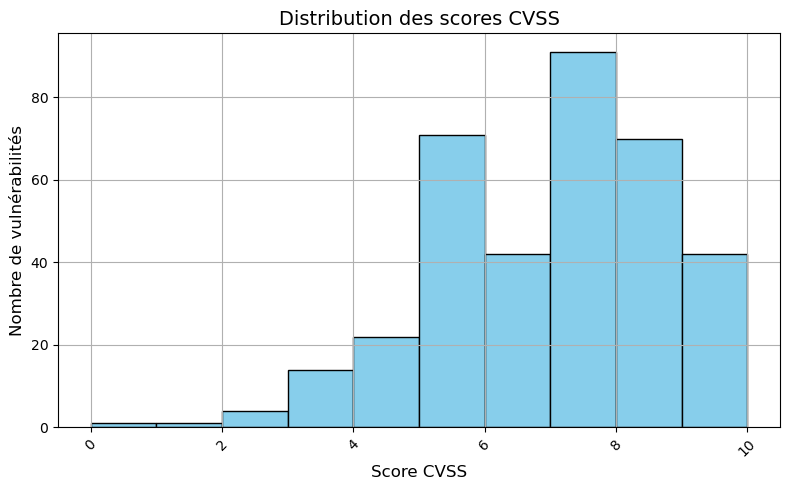

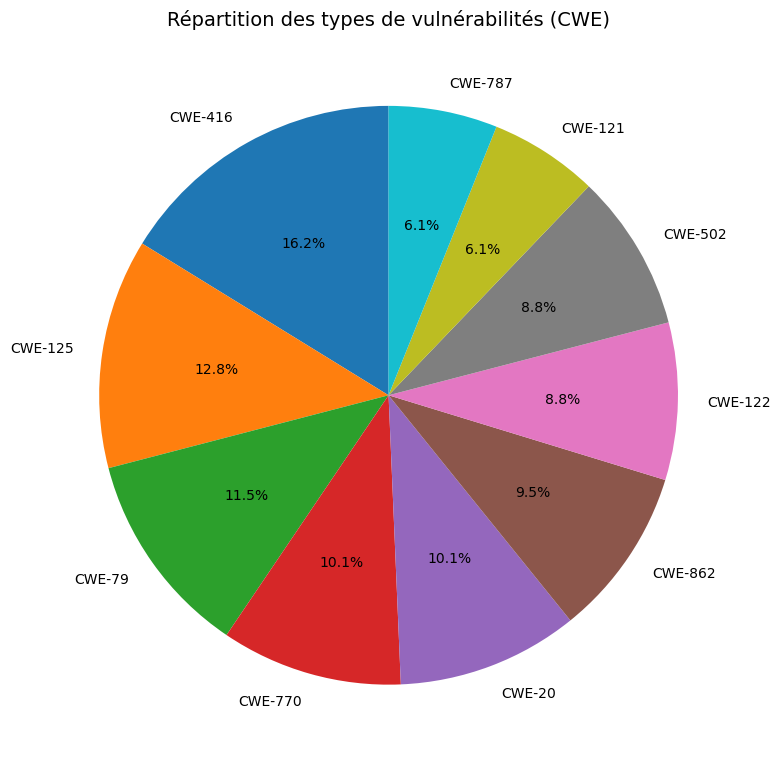

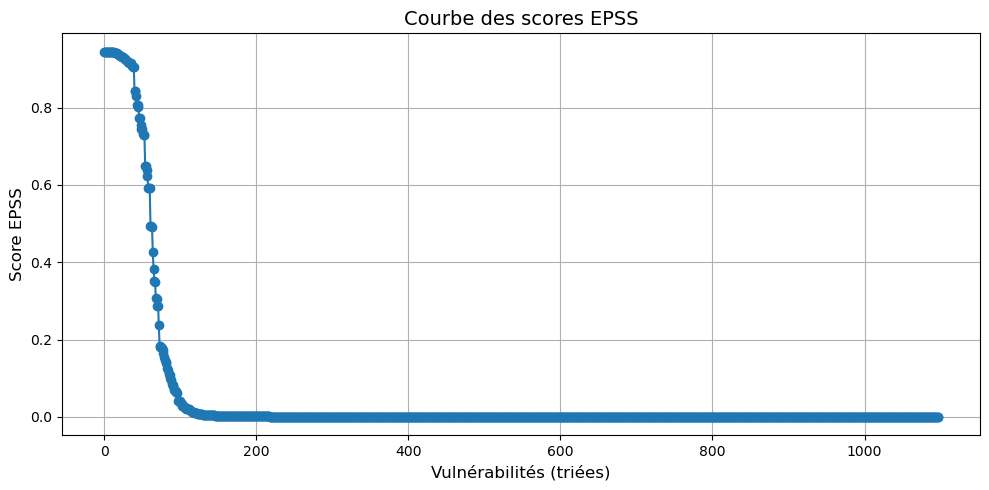

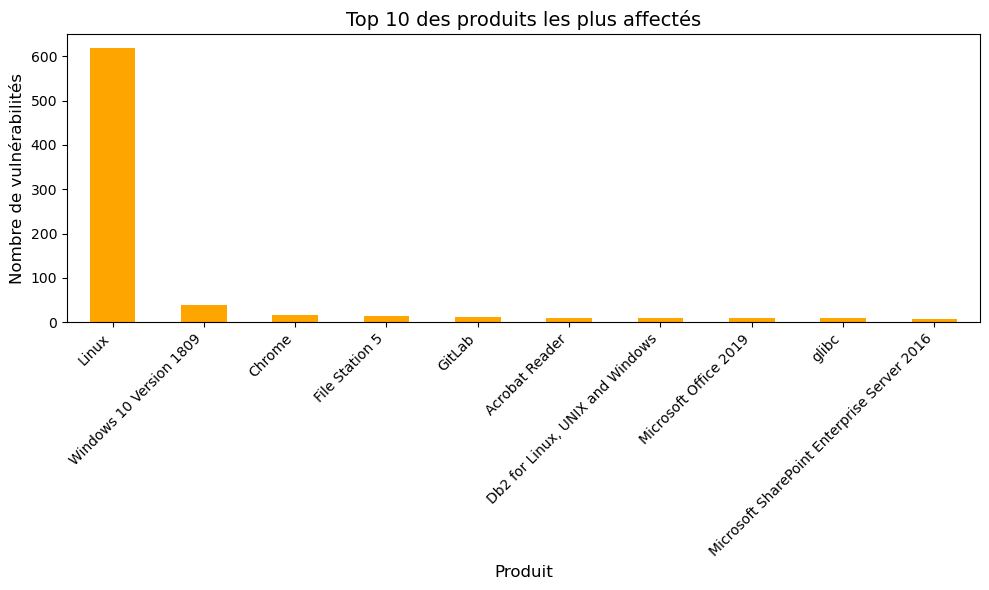

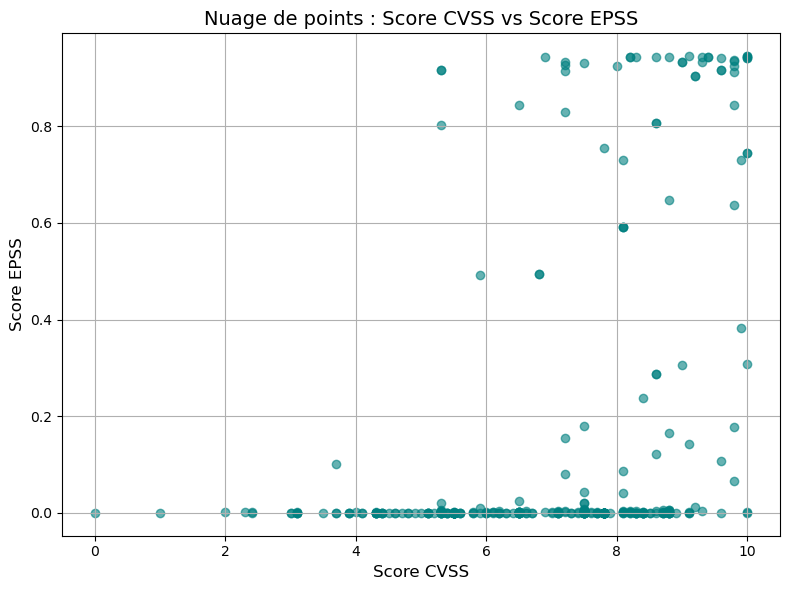

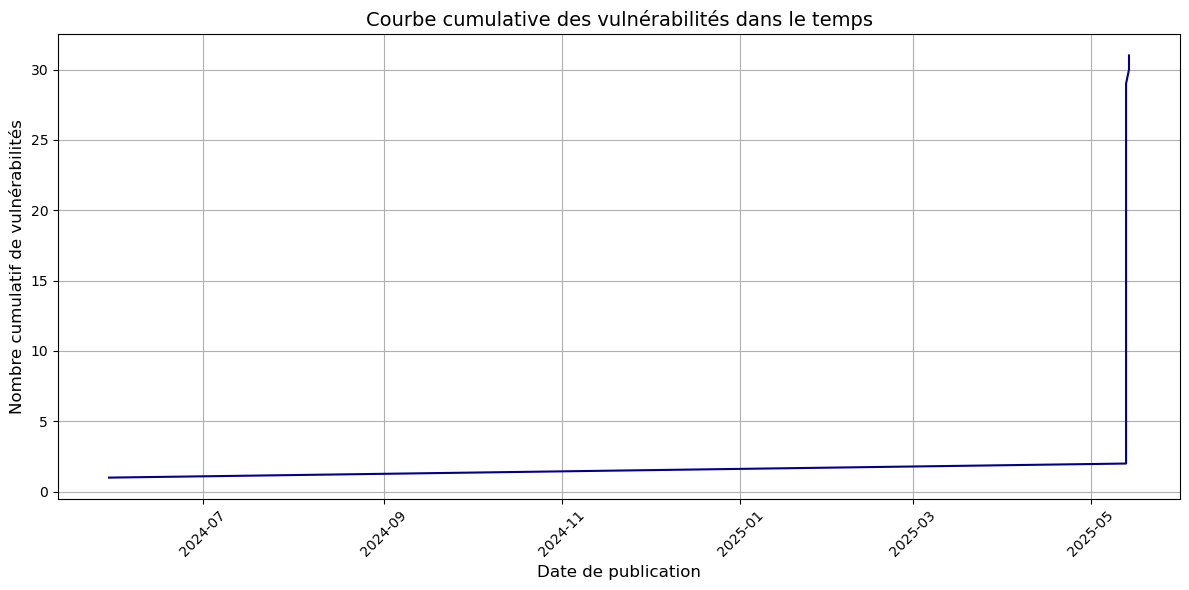

In [42]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger le fichier CSV
df = pd.read_csv("data.csv", sep=';')

# 1. Histogramme des scores CVSS
plt.figure(figsize=(8,5))
df['Score CVSS'].dropna().hist(bins=10, color='skyblue', edgecolor='black')
plt.title("Distribution des scores CVSS", fontsize=14)
plt.xlabel("Score CVSS", fontsize=12)
plt.ylabel("Nombre de vulnérabilités", fontsize=12)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# 2. Diagramme circulaire des types de vulnérabilités (CWE)
cwe_counts = df['Type CWE'].value_counts().head(10)
plt.figure(figsize=(8,8))
cwe_counts.index = cwe_counts.index.astype(str)
cwe_counts.plot.pie(autopct='%1.1f%%', startangle=90, textprops={'fontsize': 10})
plt.title("Répartition des types de vulnérabilités (CWE)", fontsize=14)
plt.ylabel("")
plt.tight_layout()
plt.show()

# 3. Courbe des scores EPSS
df_sorted = df.sort_values("Score EPSS", ascending=False)
plt.figure(figsize=(10,5))
plt.plot(df_sorted['Score EPSS'].dropna().values, marker='o')
plt.title("Courbe des scores EPSS", fontsize=14)
plt.xlabel("Vulnérabilités (triées)", fontsize=12)
plt.ylabel("Score EPSS", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Classement des produits les plus affectés
produit_counts = df['Produit'].value_counts().head(10)
plt.figure(figsize=(10,6))
produit_counts.plot(kind='bar', color='orange')
plt.title("Top 10 des produits les plus affectés", fontsize=14)
plt.xlabel("Produit", fontsize=12)
plt.ylabel("Nombre de vulnérabilités", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# 5. Nuage de points Score CVSS vs Score EPSS
df['Score CVSS'] = pd.to_numeric(df['Score CVSS'], errors='coerce')
df['Score EPSS'] = pd.to_numeric(df['Score EPSS'], errors='coerce')
df_clean = df.dropna(subset=['Score CVSS', 'Score EPSS'])

plt.figure(figsize=(8,6))
plt.scatter(df_clean['Score CVSS'], df_clean['Score EPSS'], alpha=0.6, color='teal')
plt.title("Nuage de points : Score CVSS vs Score EPSS", fontsize=14)
plt.xlabel("Score CVSS", fontsize=12)
plt.ylabel("Score EPSS", fontsize=12)
plt.grid(True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# 6. Courbe cumulative des vulnérabilités dans le temps
df['Date de publication'] = pd.to_datetime(df['Date de publication'], errors='coerce')
df_clean = df.dropna(subset=['Date de publication']).copy()
df_clean['Date de publication'] = df_clean['Date de publication'].dt.tz_localize(None)
df_sorted = df_clean.sort_values('Date de publication').copy()
df_sorted['Cumul'] = range(1, len(df_sorted) + 1)

plt.figure(figsize=(12,6))
plt.plot(df_sorted['Date de publication'], df_sorted['Cumul'], color='darkblue')
plt.title("Courbe cumulative des vulnérabilités dans le temps", fontsize=14)
plt.xlabel("Date de publication", fontsize=12)
plt.ylabel("Nombre cumulatif de vulnérabilités", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()


## Remplissage des données

In [50]:
import pandas as pd
import numpy as np

# Chargement
df = pd.read_csv("data.csv", sep=";")

# Colonnes
score_cvss_col = "Score CVSS"
score_epss_col = "Score EPSS"
severity_col = "Base Severity"
product_col = "Produit"

# Nettoyage : conversion et remplacement des valeurs manquantes
df[score_cvss_col] = pd.to_numeric(df[score_cvss_col], errors='coerce')
df[score_epss_col] = pd.to_numeric(df[score_epss_col], errors='coerce')
df[severity_col] = df[severity_col].replace(['', 'nan', 'NaN'], np.nan)

# Normalisation du score EPSS
epss_min = df[score_epss_col].min()
epss_max = df[score_epss_col].max()
df["EPSS normalisé"] = (df[score_epss_col] - epss_min) / (epss_max - epss_min)

# Arrondi pour groupement
df["EPSS arrondi"] = df["EPSS normalisé"].round(4)

# Fonction mode avec fallback
def mode_or_nan(series):
    m = series.mode()
    return m.iloc[0] if not m.empty else np.nan

# Moyennes par groupe (Produit + EPSS arrondi)
grouped = df.groupby([product_col, "EPSS arrondi"])
mean_cvss = grouped[score_cvss_col].mean()

# Moyenne globale
global_mean_cvss = df[score_cvss_col].mean()

# Fonction pour déterminer la base severity à partir du score CVSS
def get_base_severity(score):
    if pd.isna(score):
        return "de type valeur manquante"
    if 9 <= score <= 10:
        return "CRITICAL"
    elif 7 <= score < 9:
        return "HIGH"
    elif 4 <= score < 7:
        return "MEDIUM"
    elif 0 <= score < 4:
        return "LOW"
    else:
        return "de type valeur manquante"

# Fonction d’imputation (sans la partie Base Severity par mode, mais avec get_base_severity)
def impute_row(row):
    product = row[product_col]
    epss_rounded = round(row["EPSS normalisé"], 4) if not pd.isna(row["EPSS normalisé"]) else np.nan

    # Score CVSS
    if pd.isna(row[score_cvss_col]):
        if (product, epss_rounded) in mean_cvss.index and not pd.isna(mean_cvss.loc[(product, epss_rounded)]):
            row[score_cvss_col] = round(mean_cvss.loc[(product, epss_rounded)], 2)
        else:
            row[score_cvss_col] = round(global_mean_cvss, 2)

    # Base Severity par règle sur le score CVSS
    if pd.isna(row[severity_col]):
        row[severity_col] = get_base_severity(row[score_cvss_col])

    return row

# Application de l’imputation
df_imputed = df.apply(impute_row, axis=1)

# Affichage des valeurs manquantes restantes
print("Valeurs manquantes après imputation :")
print(df_imputed[[score_cvss_col, severity_col]].isna().sum())

# Sauvegarde
df_imputed.drop(columns=["EPSS normalisé", "EPSS arrondi"]).to_csv("data_complet.csv", sep=";", index=False)
print("Imputation terminée, sauvegardée dans 'data_complet.csv'.")

Valeurs manquantes après imputation :
Score CVSS       0
Base Severity    0
dtype: int64
Imputation terminée, sauvegardée dans 'data_complet.csv'.


In [52]:
df = pd.read_csv("data_complet.csv", sep=';')
df


,ID du bulletin (ANSSI),Titre du bulletin (ANSSI),Type de bulletin,Date de publication,Identifiant CVE,Score CVSS,Base Severity,Type CWE,Score EPSS,Lien du bulletin (ANSSI),Description,Éditeur/Vendor,Produit,Versions affectées
0,CERTFR-2025-AVI-0392,Multiples vulnérabilités dans Mattermost Serve...,avis,"Tue, 13 May 2025 00:00:00 +0000",CVE-2025-4573,4.1,MEDIUM,CWE-90,0.00028,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,"Mattermost versions 10.7.x <= 10.7.1, 10.6.x <...",Mattermost,Mattermost,"10.7.0, 10.6.0, 10.5.0, 9.11.0"
1,CERTFR-2025-AVI-0392,Multiples vulnérabilités dans Mattermost Serve...,avis,"Tue, 13 May 2025 00:00:00 +0000",CVE-2025-4128,3.1,LOW,CWE-863,0.00023,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,"Mattermost versions 10.5.x <= 10.5.4, 9.11.x <...",Mattermost,Mattermost,"10.5.0, 9.11.0"
2,CERTFR-2025-AVI-0396,Multiples vulnérabilités dans les produits SAP...,avis,"Tue, 13 May 2025 00:00:00 +0000",CVE-2025-30009,6.1,MEDIUM,CWE-79,0.00116,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,he Live Auction Cockpit in SAP Supplier Relati...,SAP_SE,SAP Supplier Relationship Management (Live Auc...,SRM_SERVER 7.14
3,CERTFR-2025-AVI-0396,Multiples vulnérabilités dans les produits SAP...,avis,"Tue, 13 May 2025 00:00:00 +0000",CVE-2025-43002,4.3,MEDIUM,CWE-472,0.00035,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,SAP S4CORE OData meta-data property allows an ...,SAP_SE,SAP S4/HANA (OData meta-data property),"S4CORE 102, 103, 104, 105, 106"
4,CERTFR-2025-AVI-0396,Multiples vulnérabilités dans les produits SAP...,avis,"Tue, 13 May 2025 00:00:00 +0000",CVE-2025-0061,8.7,HIGH,CWE-497,0.00049,https://www.cert.ssi.gouv.fr/avis/CERTFR-2025-...,SAP BusinessObjects Business Intelligence Plat...,SAP_SE,SAP BusinessObjects Business Intelligence Plat...,"ENTERPRISE 420, 430, 2025"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1139,CERTFR-2025-ALE-005,Vulnérabilité dans SAP NetWeaver (28 avril 2025),alerte,"Mon, 28 Apr 2025 00:00:00 +0000",CVE-2025-31324,10.0,CRITICAL,CWE-434,0.74446,https://www.cert.ssi.gouv.fr/alerte/CERTFR-202...,SAP NetWeaver Visual Composer Metadata Uploade...,SAP_SE,SAP NetWeaver (Visual Composer development ser...,VCFRAMEWORK 7.50
1140,CERTFR-2025-ALE-006,Vulnérabilité dans les produits Fortinet (13 m...,alerte,"Tue, 13 May 2025 00:00:00 +0000",CVE-2025-32756,9.6,CRITICAL,CWE-121,0.10736,https://www.cert.ssi.gouv.fr/alerte/CERTFR-202...,A stack-based buffer overflow vulnerability [C...,Fortinet,FortiVoice,"7.2.0, 7.0.0, 6.4.0"
1141,CERTFR-2025-ALE-007,Multiples vulnérabilités dans Ivanti Endpoint ...,alerte,"Wed, 14 May 2025 00:00:00 +0000",CVE-2025-4428,7.2,HIGH,CWE-94,0.15539,https://www.cert.ssi.gouv.fr/alerte/CERTFR-202...,Remote Code Execution in API component in Ivan...,Ivanti,Endpoint Manager Mobile,NaN
1142,CERTFR-2025-ALE-007,Multiples vulnérabilités dans Ivanti Endpoint ...,alerte,"Wed, 14 May 2025 00:00:00 +0000",CVE-2025-4427,5.3,MEDIUM,CWE-288,0.80199,https://www.cert.ssi.gouv.fr/alerte/CERTFR-202...,An authentication bypass in the API component ...,Ivanti,Endpoint Manager Mobile,NaN


## visualisation données complètes

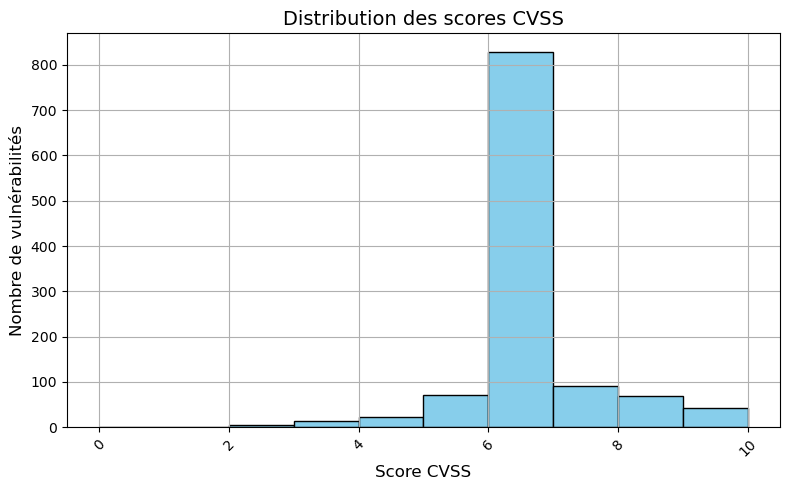

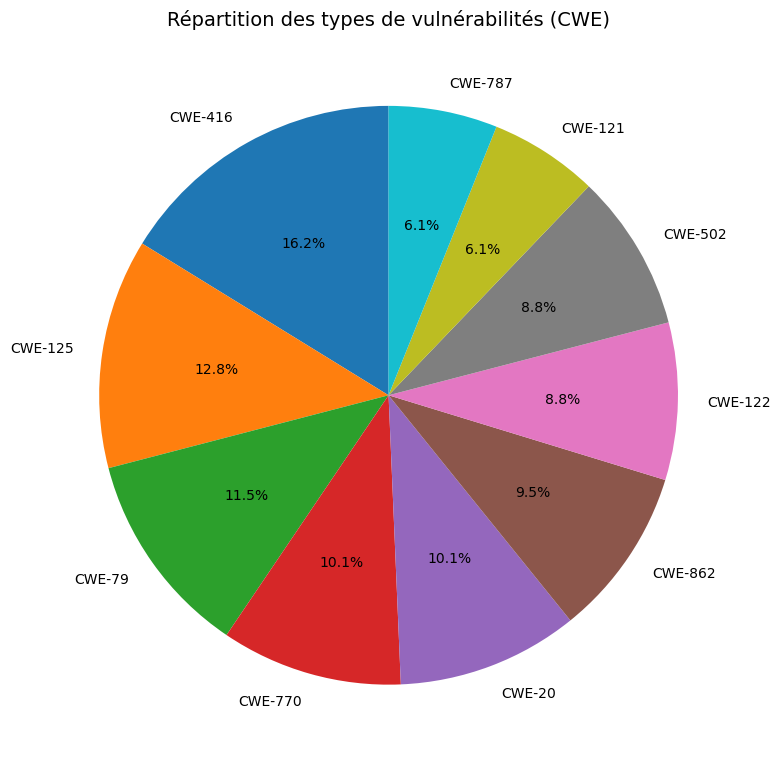

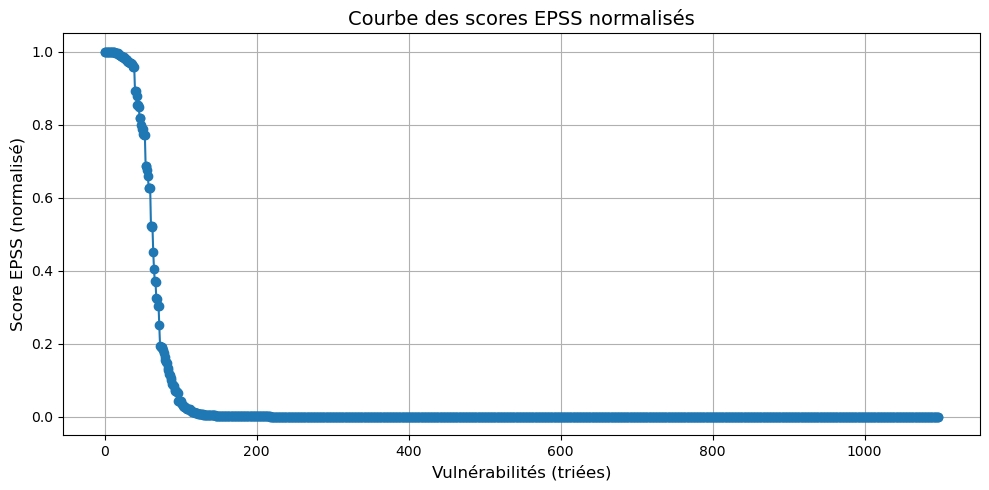

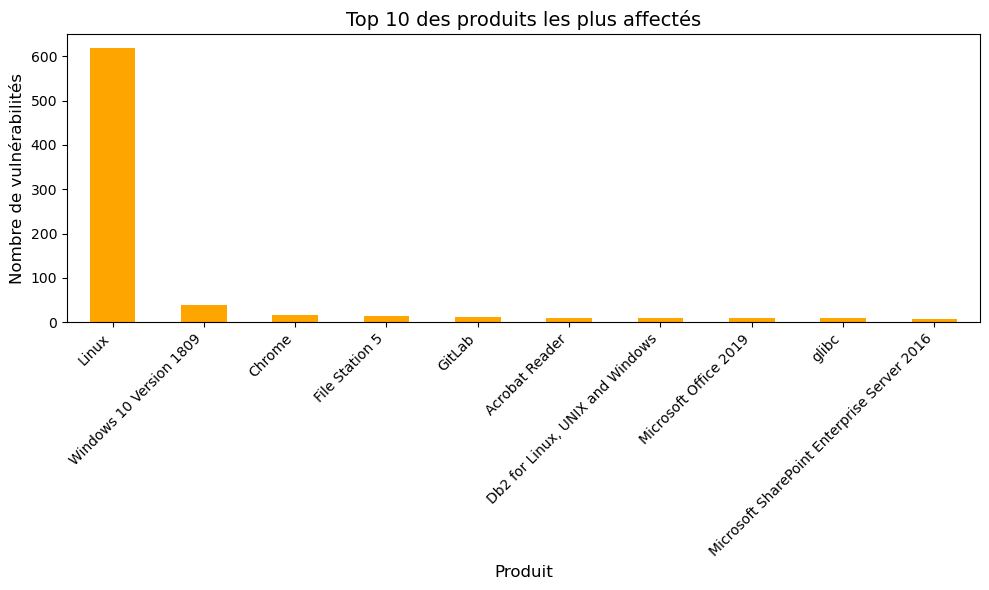

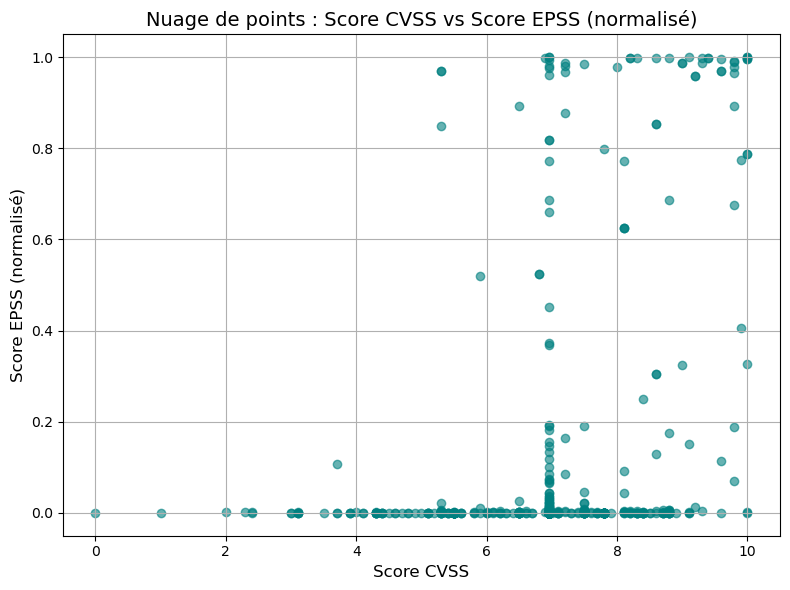

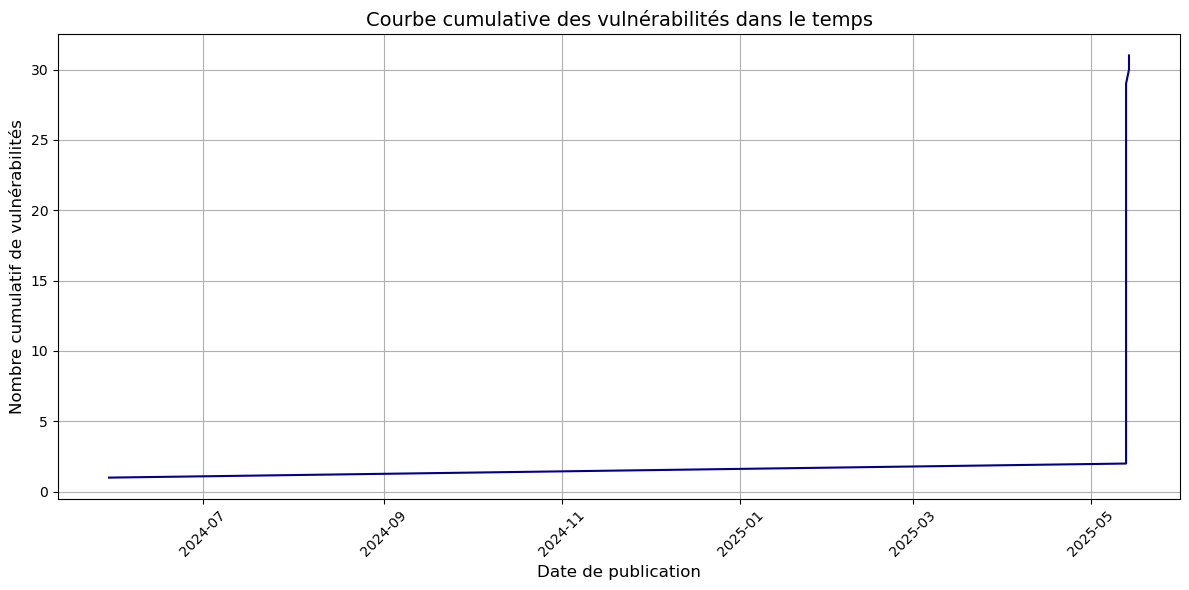

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# Charger le fichier CSV
df = pd.read_csv("data_complet.csv", sep=';')

# Conversion des champs numériques
df['Score CVSS'] = pd.to_numeric(df['Score CVSS'], errors='coerce')
df['Score EPSS'] = pd.to_numeric(df['Score EPSS'], errors='coerce')

# Création du score EPSS normalisé si pas déjà dans le fichier
if 'EPSS normalisé' not in df.columns:
    epss_min = df['Score EPSS'].min()
    epss_max = df['Score EPSS'].max()
    df['EPSS normalisé'] = (df['Score EPSS'] - epss_min) / (epss_max - epss_min)

# 1. Histogramme des scores CVSS
plt.figure(figsize=(8,5))
df['Score CVSS'].dropna().hist(bins=10, color='skyblue', edgecolor='black')
plt.title("Distribution des scores CVSS", fontsize=14)
plt.xlabel("Score CVSS", fontsize=12)
plt.ylabel("Nombre de vulnérabilités", fontsize=12)
plt.xticks(fontsize=10, rotation=45)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# 2. Diagramme circulaire des types de vulnérabilités (CWE)
cwe_counts = df['Type CWE'].value_counts().head(10)
plt.figure(figsize=(8,8))
cwe_counts.index = cwe_counts.index.astype(str)
cwe_counts.plot.pie(autopct='%1.1f%%', startangle=90, textprops={'fontsize': 10})
plt.title("Répartition des types de vulnérabilités (CWE)", fontsize=14)
plt.ylabel("")
plt.tight_layout()
plt.show()

# 3. Courbe des scores EPSS normalisés
df_sorted = df.sort_values("EPSS normalisé", ascending=False)
plt.figure(figsize=(10,5))
plt.plot(df_sorted['EPSS normalisé'].dropna().values, marker='o')
plt.title("Courbe des scores EPSS normalisés", fontsize=14)
plt.xlabel("Vulnérabilités (triées)", fontsize=12)
plt.ylabel("Score EPSS (normalisé)", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Classement des produits les plus affectés
produit_counts = df['Produit'].value_counts().head(10)
plt.figure(figsize=(10,6))
produit_counts.plot(kind='bar', color='orange')
plt.title("Top 10 des produits les plus affectés", fontsize=14)
plt.xlabel("Produit", fontsize=12)
plt.ylabel("Nombre de vulnérabilités", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# 5. Nuage de points : Score CVSS vs EPSS normalisé
df_clean = df.dropna(subset=['Score CVSS', 'EPSS normalisé'])
plt.figure(figsize=(8,6))
plt.scatter(df_clean['Score CVSS'], df_clean['EPSS normalisé'], alpha=0.6, color='teal')
plt.title("Nuage de points : Score CVSS vs Score EPSS (normalisé)", fontsize=14)
plt.xlabel("Score CVSS", fontsize=12)
plt.ylabel("Score EPSS (normalisé)", fontsize=12)
plt.grid(True)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# 6. Courbe cumulative des vulnérabilités dans le temps
df['Date de publication'] = pd.to_datetime(df['Date de publication'], errors='coerce')
df_clean_date = df.dropna(subset=['Date de publication']).copy()
df_clean_date['Date de publication'] = df_clean_date['Date de publication'].dt.tz_localize(None)
df_sorted_date = df_clean_date.sort_values('Date de publication').copy()
df_sorted_date['Cumul'] = range(1, len(df_sorted_date) + 1)

plt.figure(figsize=(12,6))
plt.plot(df_sorted_date['Date de publication'], df_sorted_date['Cumul'], color='darkblue')
plt.title("Courbe cumulative des vulnérabilités dans le temps", fontsize=14)
plt.xlabel("Date de publication", fontsize=12)
plt.ylabel("Nombre cumulatif de vulnérabilités", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True)
plt.tight_layout()
plt.show()




## Étape 6 : Model Machine Learning

### ML supervisé — Prédiction du Score CVSS (régression)

Mean Squared Error (MSE) : 0.4358
R² score : 0.8232


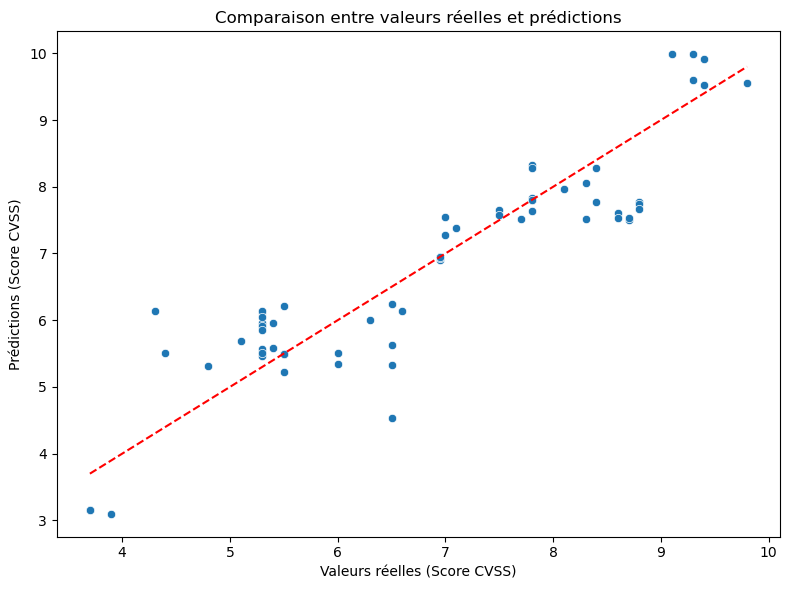

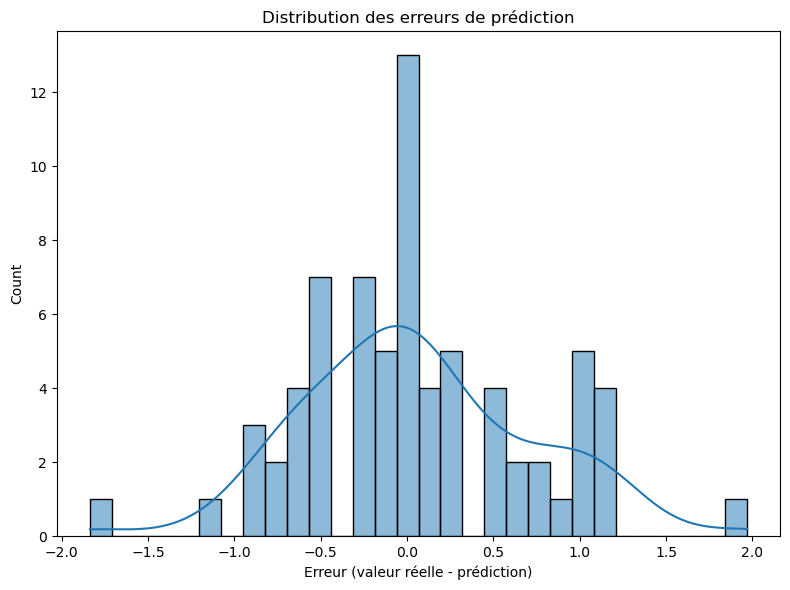

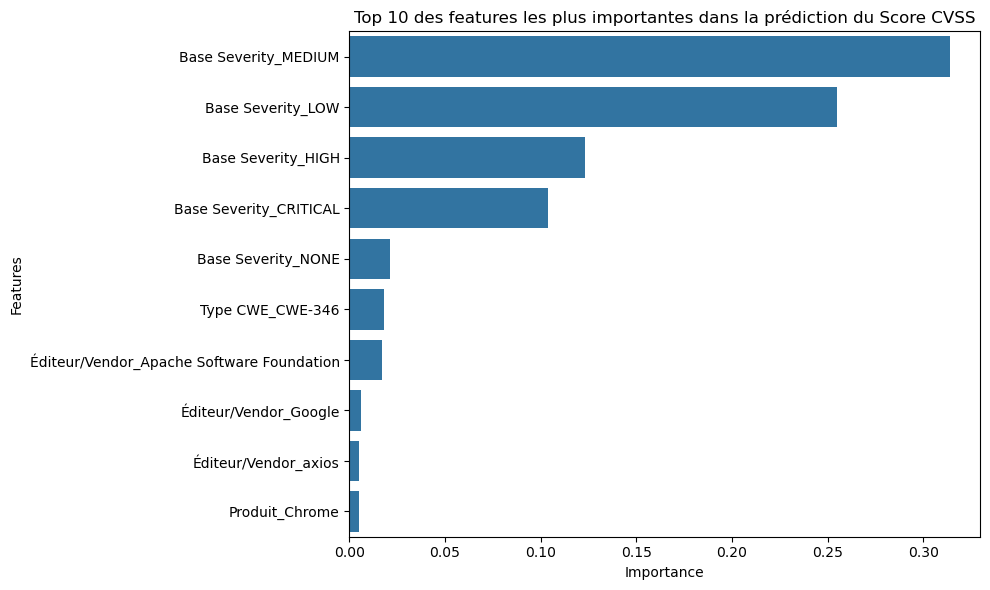

Nombre d'échantillons utilisés : 297


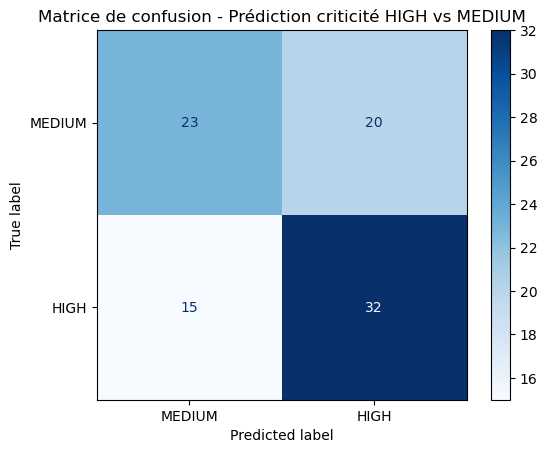

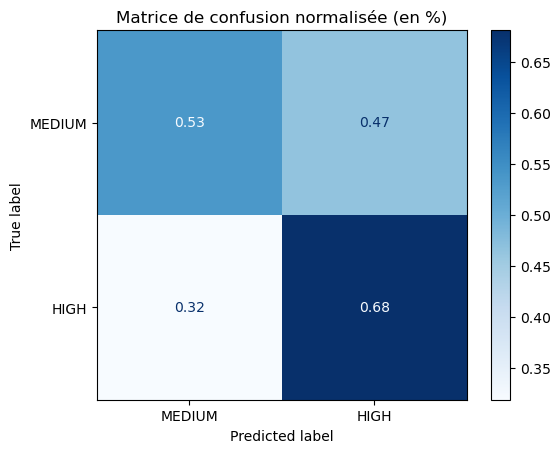

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Chargement du fichier CSV
df = pd.read_csv("data_complet.csv", sep=";")

# Conversion des champs numériques
df['Score CVSS'] = pd.to_numeric(df['Score CVSS'], errors='coerce')
df['Score EPSS'] = pd.to_numeric(df['Score EPSS'], errors='coerce')

# Création de la colonne EPSS normalisé si nécessaire
if 'EPSS normalisé' not in df.columns:
    epss_min = df['Score EPSS'].min()
    epss_max = df['Score EPSS'].max()
    df['EPSS normalisé'] = (df['Score EPSS'] - epss_min) / (epss_max - epss_min)

# --- Préparation du modèle ---

# Nouvelle target
target = 'Score CVSS'

# Colonnes explicatives (on enlève 'Score CVSS' car c’est la target maintenant)
features = ['Type CWE', 'Base Severity', 'Éditeur/Vendor', 'Produit']

# Supprimer les lignes sans target ni features
df = df.dropna(subset=features + [target])

# Séparer X et y
X = df[features]
y = df[target]

# Colonnes catégorielles (ici, toutes les features sont catégorielles)
categorical_cols = features
numerical_cols = []  # plus de colonnes numériques dans les features

# Prétraitement
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Modèle
model = RandomForestRegressor(random_state=42)

# Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', model)
])

# Split train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entraînement
pipeline.fit(X_train, y_train)

# Prédictions
y_pred = pipeline.predict(X_test)

# Évaluation
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error (MSE) : {mse:.4f}")
print(f"R² score : {r2:.4f}")

# --- Visualisation ---

# 1. Valeurs réelles vs prédictions
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Valeurs réelles (Score CVSS)")
plt.ylabel("Prédictions (Score CVSS)")
plt.title("Comparaison entre valeurs réelles et prédictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.tight_layout()
plt.show()

# 2. Distribution des erreurs
errors = y_test - y_pred
plt.figure(figsize=(8,6))
sns.histplot(errors, bins=30, kde=True)
plt.xlabel("Erreur (valeur réelle - prédiction)")
plt.title("Distribution des erreurs de prédiction")
plt.tight_layout()
plt.show()

# 3. Importance des features
ohe = pipeline.named_steps['preprocessor'].named_transformers_['cat']
feature_names = ohe.get_feature_names_out(categorical_cols)
importances = pipeline.named_steps['regressor'].feature_importances_

# Top N
top_n = 10
indices = importances.argsort()[::-1][:top_n]

plt.figure(figsize=(10,6))
sns.barplot(x=importances[indices], y=[feature_names[i] for i in indices])
plt.title(f"Top {top_n} des features les plus importantes dans la prédiction du Score CVSS")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

# Préparation des données
df_crit = df[df['Base Severity'].isin(['HIGH', 'MEDIUM'])].dropna(subset=['Base Severity', 'Score EPSS'])
X = df_crit[['Score EPSS']]  # Ajouter plus de features si possible
y = LabelEncoder().fit_transform(df_crit['Base Severity'])
print("Nombre d'échantillons utilisés :", df_crit.shape[0])

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Modèle
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['MEDIUM', 'HIGH'])
disp.plot(cmap='Blues')
plt.title("Matrice de confusion - Prédiction criticité HIGH vs MEDIUM")
plt.show()

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Normalisation par ligne (par classe réelle)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Affichage
disp = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=['MEDIUM', 'HIGH'])
disp.plot(cmap='Blues', values_format=".2f")
plt.title("Matrice de confusion normalisée (en %)")
plt.show()




### ML non supervisé — Clustering des vulnérabilités

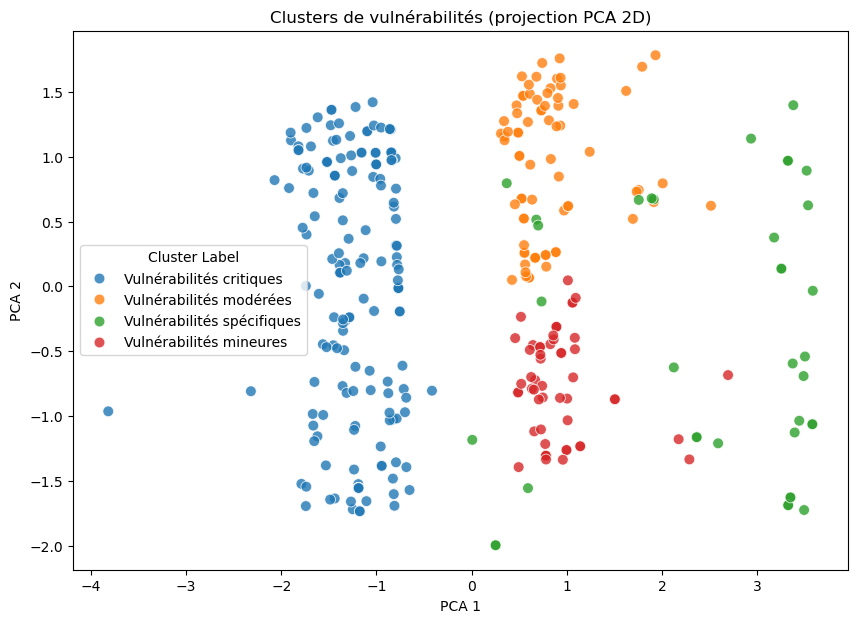

Taille des clusters :
cluster_label
Vulnérabilités critiques      173
Vulnérabilités modérées        84
Vulnérabilités mineures        57
Vulnérabilités spécifiques     37
Name: count, dtype: int64

Statistiques par cluster (moyennes) :
                            Score CVSS  Score EPSS  Base Severity Enc  \
cluster_label                                                           
Vulnérabilités critiques      5.500289    0.003236           2.895954   
Vulnérabilités mineures       8.080702    0.032208           0.947368   
Vulnérabilités modérées       8.079762    0.012537           0.892857   
Vulnérabilités spécifiques    8.555405    0.886522           0.837838   

                            Type CWE Enc  
cluster_label                             
Vulnérabilités critiques       55.751445  
Vulnérabilités mineures        22.421053  
Vulnérabilités modérées        75.940476  
Vulnérabilités spécifiques     48.405405  


/var/folders/r7/2mh594td6tq3pqzv49xfkh7r0000gn/T/ipykernel_2082/3948591213.py:57: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='cluster_label', data=df_unsup, palette='tab10')


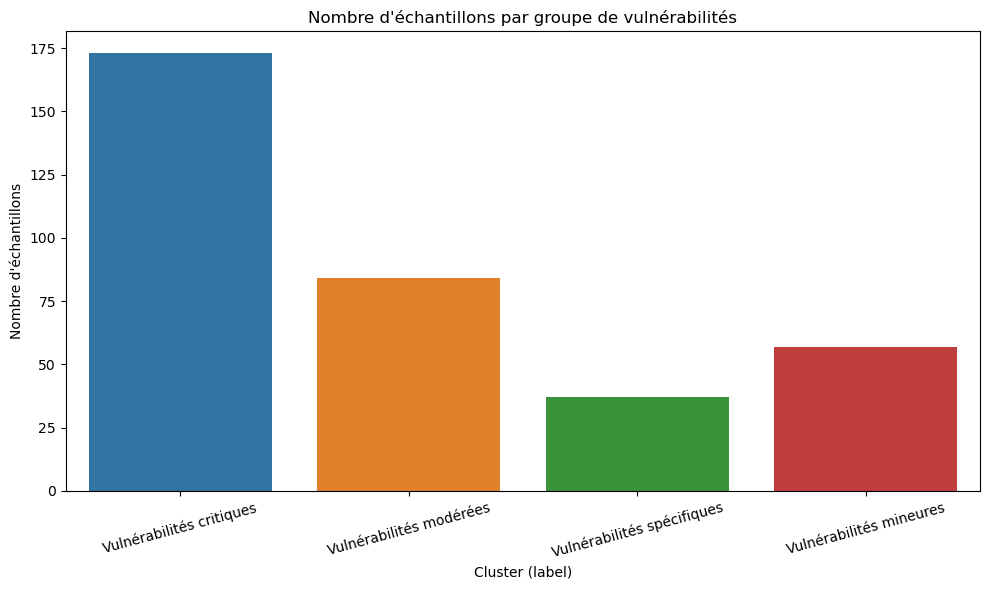

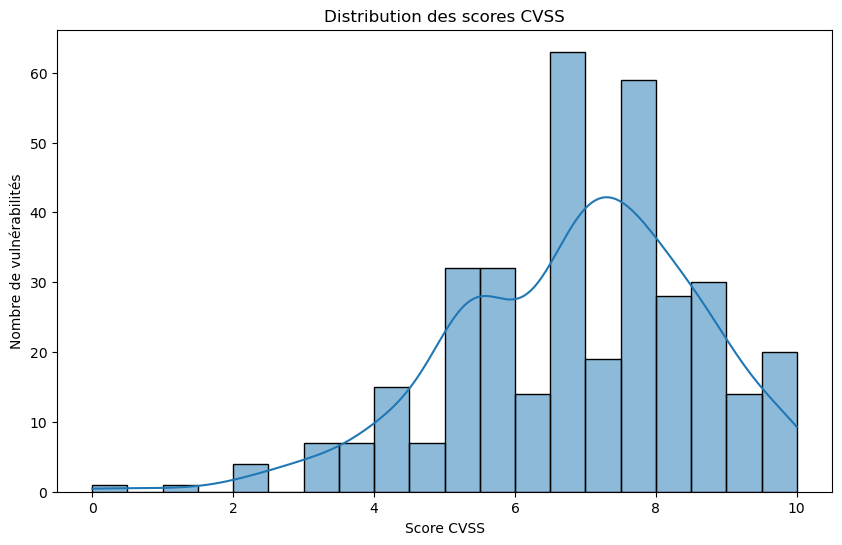

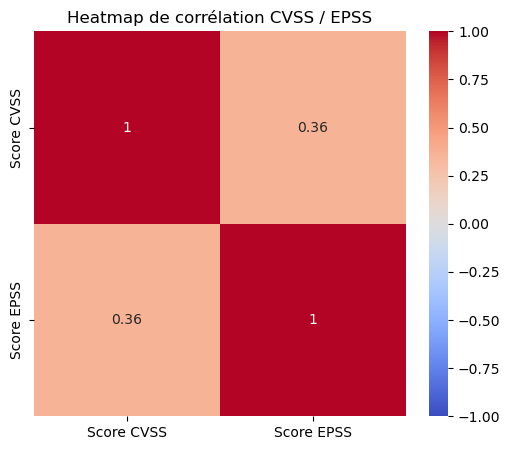

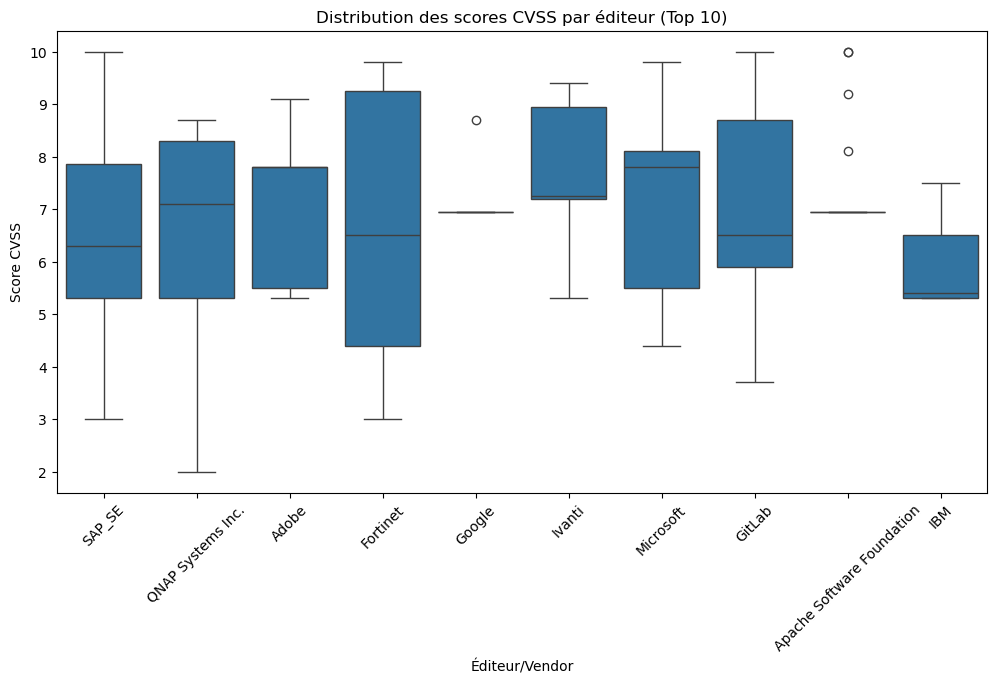

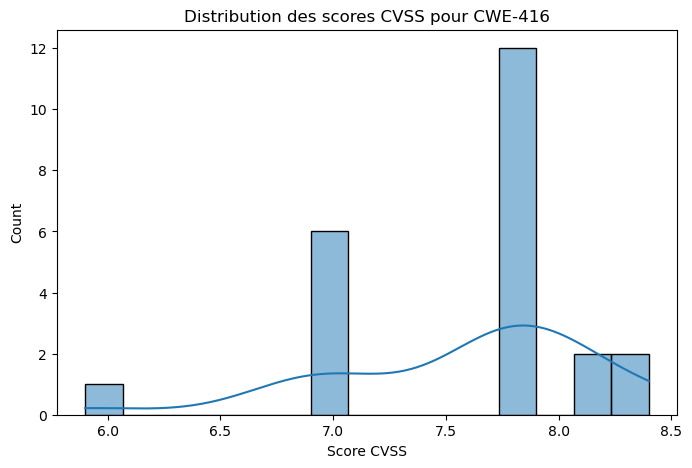

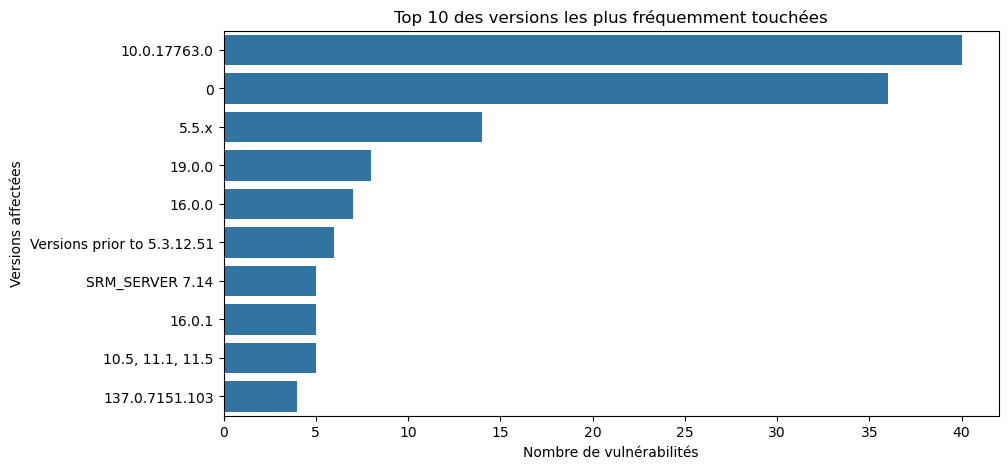

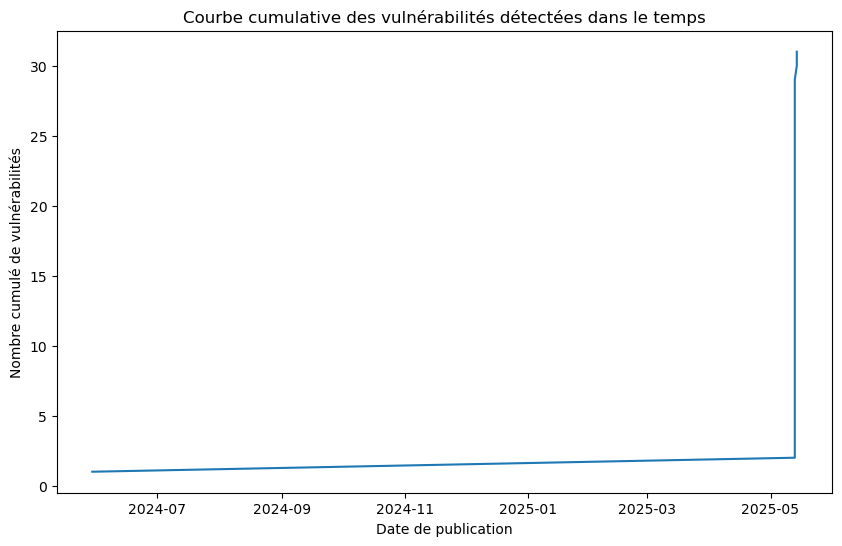

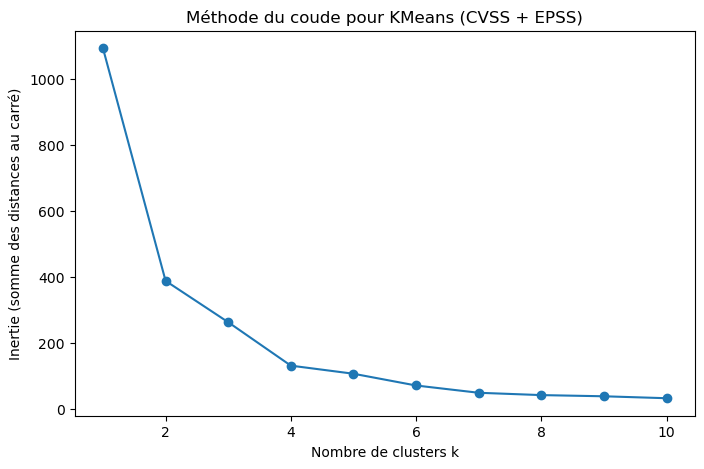

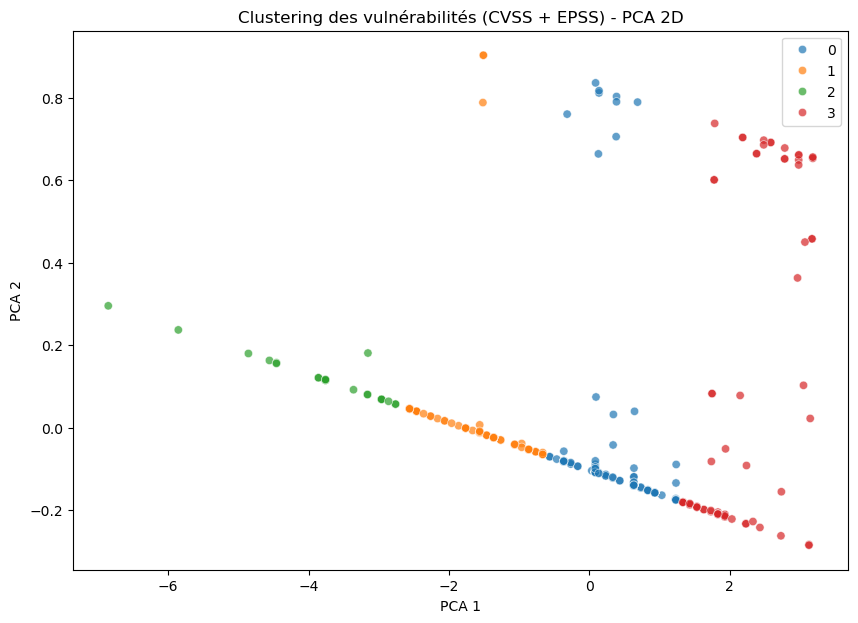

Variance expliquée par chaque composante :
Composante 1: 0.979
Composante 2: 0.021


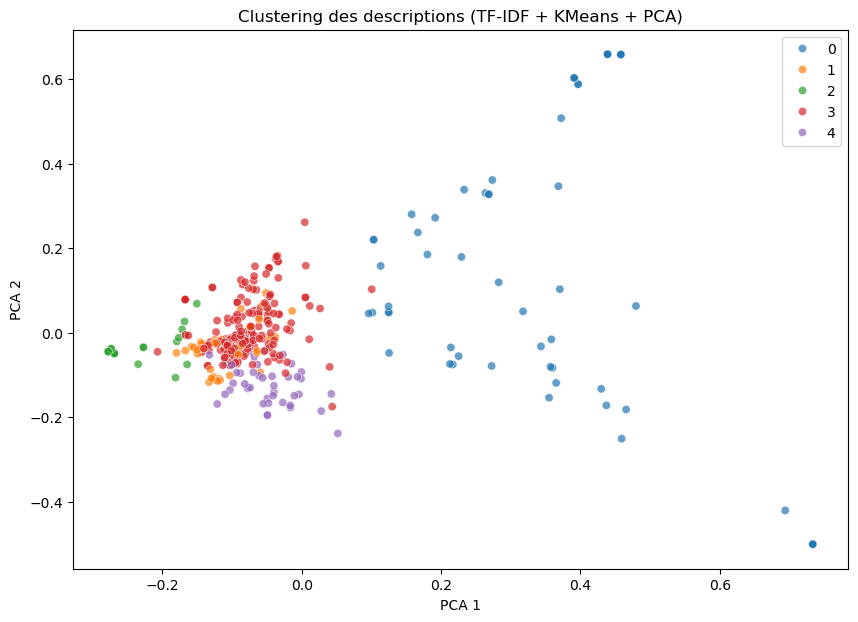

In [55]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

features_unsup = ['Score CVSS', 'Score EPSS', 'Base Severity', 'Type CWE']

df_unsup = df.dropna(subset=features_unsup).copy()

# Encodage catégoriel avec .loc pour éviter warning
df_unsup.loc[:, 'Base Severity Enc'] = LabelEncoder().fit_transform(df_unsup['Base Severity'])
df_unsup.loc[:, 'Type CWE Enc'] = LabelEncoder().fit_transform(df_unsup['Type CWE'])

X_unsup = df_unsup[['Score CVSS', 'Score EPSS', 'Base Severity Enc', 'Type CWE Enc']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_unsup)

k = 4
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

df_unsup['cluster'] = clusters

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

cluster_labels = {
    0: "Vulnérabilités modérées",
    1: "Vulnérabilités mineures",
    2: "Vulnérabilités critiques",
    3: "Vulnérabilités spécifiques"
}

label_names = df_unsup['cluster'].map(cluster_labels)

plt.figure(figsize=(10, 7))
palette = sns.color_palette('tab10', len(cluster_labels))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=label_names, palette=palette, s=60, alpha=0.8)
plt.title('Clusters de vulnérabilités (projection PCA 2D)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster Label')
plt.show()

df_unsup['cluster_label'] = label_names

print("Taille des clusters :")
print(df_unsup['cluster_label'].value_counts())

print("\nStatistiques par cluster (moyennes) :")
print(df_unsup.groupby('cluster_label')[['Score CVSS', 'Score EPSS', 'Base Severity Enc', 'Type CWE Enc']].mean())

plt.figure(figsize=(10,6))
sns.countplot(x='cluster_label', data=df_unsup, palette='tab10')
plt.title("Nombre d'échantillons par groupe de vulnérabilités")
plt.xlabel("Cluster (label)")
plt.ylabel("Nombre d'échantillons")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
sns.histplot(df['Score CVSS'].dropna(), bins=20, kde=True)
plt.title("Distribution des scores CVSS")
plt.xlabel("Score CVSS")
plt.ylabel("Nombre de vulnérabilités")
plt.show()

plt.figure(figsize=(6,5))
sns.heatmap(df[['Score CVSS', 'Score EPSS']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Heatmap de corrélation CVSS / EPSS")
plt.show()

plt.figure(figsize=(12,6))
top_vendors = df['Éditeur/Vendor'].value_counts().nlargest(10).index
sns.boxplot(data=df[df['Éditeur/Vendor'].isin(top_vendors)], x='Éditeur/Vendor', y='Score CVSS')
plt.title("Distribution des scores CVSS par éditeur (Top 10)")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8,5))
sns.histplot(df[df['Type CWE'] == 'CWE-416']['Score CVSS'].dropna(), bins=15, kde=True)
plt.title("Distribution des scores CVSS pour CWE-416")
plt.xlabel("Score CVSS")
plt.show()

top_versions = df['Versions affectées'].value_counts().nlargest(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_versions.values, y=top_versions.index)
plt.title("Top 10 des versions les plus fréquemment touchées")
plt.xlabel("Nombre de vulnérabilités")
plt.ylabel("Versions affectées")
plt.show()

df['Date de publication'] = pd.to_datetime(df['Date de publication'], errors='coerce')
df_sorted = df.dropna(subset=['Date de publication']).sort_values('Date de publication')
df_sorted['cumulative_count'] = range(1, len(df_sorted) + 1)

plt.figure(figsize=(10,6))
plt.plot(df_sorted['Date de publication'], df_sorted['cumulative_count'])
plt.title("Courbe cumulative des vulnérabilités détectées dans le temps")
plt.xlabel("Date de publication")
plt.ylabel("Nombre cumulé de vulnérabilités")
plt.show()


X_numeric = df[['Score CVSS', 'Score EPSS']].dropna()

inertia = []
K_range = range(1, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_numeric)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker='o')
plt.title("Méthode du coude pour KMeans (CVSS + EPSS)")
plt.xlabel("Nombre de clusters k")
plt.ylabel("Inertie (somme des distances au carré)")
plt.show()

k = 4  # choisi en fonction de la méthode du coude
kmeans = KMeans(n_clusters=k, random_state=42)
clusters = kmeans.fit_predict(X_numeric)

df['cluster'] = pd.NA
df.loc[X_numeric.index, 'cluster'] = clusters

# Visualisation avec PCA 2D
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_numeric)

plt.figure(figsize=(10,7))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=clusters, palette='tab10', alpha=0.7)
plt.title("Clustering des vulnérabilités (CVSS + EPSS) - PCA 2D")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()

pca_full = PCA(n_components=2)
pca_full.fit(X_numeric)

print("Variance expliquée par chaque composante :")
for i, var in enumerate(pca_full.explained_variance_ratio_):
    print(f"Composante {i+1}: {var:.3f}")

from sklearn.feature_extraction.text import TfidfVectorizer

# Nettoyage simple
df_text = df.dropna(subset=['Description'])
texts = df_text['Description'].values

vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X_tfidf = vectorizer.fit_transform(texts)

# KMeans
k = 5
kmeans_desc = KMeans(n_clusters=k, random_state=42)
clusters_desc = kmeans_desc.fit_predict(X_tfidf)

# PCA pour visualisation
pca_desc = PCA(n_components=2)
X_desc_pca = pca_desc.fit_transform(X_tfidf.toarray())

plt.figure(figsize=(10,7))
sns.scatterplot(x=X_desc_pca[:,0], y=X_desc_pca[:,1], hue=clusters_desc, palette='tab10', alpha=0.7)
plt.title("Clustering des descriptions (TF-IDF + KMeans + PCA)")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.show()



## Étape 7 : Génération d'Alertes et Notifications Email

In [ ]:
import smtplib
from email.mime.text import MIMEText
from dotenv import load_dotenv
import os
import pandas as pd

# Charger les variables d'environnement
load_dotenv()
from_email = os.getenv("EMAIL_ADDRESS")
password = os.getenv("EMAIL_PASSWORD")

# Fonction d'envoi d'email
def send_email(to_email, subject, body):
    msg = MIMEText(body)
    msg['From'] = from_email
    msg['To'] = to_email
    msg['Subject'] = subject

    try:
        server = smtplib.SMTP('smtp.office365.com', 587)
        server.starttls()
        server.login(from_email, password)
        server.sendmail(from_email, to_email, msg.as_string())
        server.quit()
        print(f"✅ Email envoyé à {to_email}.")
    except Exception as e:
        print(f"❌ Erreur lors de l'envoi de l'email : {e}")

# 1. Charger les données
df = pd.read_csv("data_complet.csv", sep=";")

# 2. Définir les critères
# Exemples : criticité = 'Critical', système = 'Linux'
CRITICITE_VISEE = "Critical"
SYSTEME_VISE = "GitLab"  # Recherché dans Éditeur/Vendor ou Produit

# 3. Filtrage des vulnérabilités critiques liées à Linux
df_filtered = df[
    (df['Base Severity'].str.strip().str.lower() == CRITICITE_VISEE.lower()) &
    (
        df['Produit'].str.contains(SYSTEME_VISE, case=False, na=False) |
        df['Éditeur/Vendor'].str.contains(SYSTEME_VISE, case=False, na=False)
    )
]

# 4. Envoi d’un mail pour chaque menace filtrée
for _, row in df_filtered.iterrows():
    titre = row['Titre du bulletin (ANSSI)']
    produit = row['Produit']
    score_cvss = row['Score CVSS']
    score_epss = row['Score EPSS']
    lien = row['Lien du bulletin (ANSSI)']
    date = row['Date de publication']

    body = (
        f"🚨 Alerte de sécurité critique ({CRITICITE_VISEE}) détectée 🚨\n\n"
        f"📝 Titre : {titre}\n"
        f"📅 Date : {date}\n"
        f"💻 Produit concerné : {produit}\n"
        f"📊 Score CVSS : {score_cvss}\n"
        f"📈 Score EPSS : {score_epss}\n"
        f"🔗 Lien ANSSI : {lien}\n\n"
        f"Veuillez appliquer un correctif dès que possible."
    )

    send_email(
        "thibault.bial@efrei.net",  # à personnaliser
        f"[ALERTE] {produit} - {CRITICITE_VISEE} vulnérabilité",
        body
    )


✅ Email envoyé à thibault.bial@efrei.net.
✅ Email envoyé à thibault.bial@efrei.net.
